# Predykcja cen akcji spółki Microsoft z wykorzystaniem LSTM (ang. Long Short-Term Memory)

## Niezbędne biblioteki

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from keras.api.models import Sequential
from keras.api.layers import *
from keras.api.optimizers import *
from keras.api.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
import tensorflow as tf

# Enable eager execution
tf.data.experimental.enable_debug_mode()

In [3]:
tf.executing_eagerly()

True

## Zbieranie danych
 * Zakres dat: od `01-01-2010` do `01-01-2024`
 * Oznaczenie spółki: `MSFT.US`

In [4]:
# Ścieżka do pliku CSV w repozytorium
csv_path = './msft_us_historical_data.csv'

# Sprawdzenie, czy plik istnieje
if not os.path.exists(csv_path):
    # URL do pobrania danych historycznych dla MSFT.US
    url = 'https://stooq.com/q/d/l/?s=msft.us&i=d&d1=20100101&d2=20240101'
    
    # Pobieranie danych
    response = requests.get(url)
    
    # Sprawdzenie, czy żądanie się powiodło
    if response.status_code == 200:
        # Zapisanie danych do pliku CSV w repozytorium
        with open(csv_path, 'wb') as file:
            file.write(response.content)
        
        print(f'Dane zostały pobrane i zapisane do {csv_path}')
    else:
        print(f'Błąd podczas pobierania danych: {response.status_code}')
else:
    print(f'Plik {csv_path} już istnieje')

# Wczytanie danych do DataFrame
df = pd.read_csv(csv_path)

# Wyświetlenie pierwszych kilku wierszy
print(df.head())

# Wyświetlenie podstawowych informacji o danych
print(df.info())

# Zmiana typu kolumny 'Date' na typ daty
df['Date'] = pd.to_datetime(df['Date'])

Plik ./msft_us_historical_data.csv już istnieje
         Date     Open     High      Low    Close        Volume
0  2010-01-04  24.0854  24.4389  24.0358  24.3178  4.886916e+07
1  2010-01-05  24.2542  24.4389  24.0765  24.3267  6.331174e+07
2  2010-01-06  24.2642  24.4230  23.9852  24.1758  7.403254e+07
3  2010-01-07  24.0537  24.1232  23.7221  23.9257  6.434577e+07
4  2010-01-08  23.7837  24.2642  23.7608  24.0934  6.515561e+07
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3522 non-null   object 
 1   Open    3522 non-null   float64
 2   High    3522 non-null   float64
 3   Low     3522 non-null   float64
 4   Close   3522 non-null   float64
 5   Volume  3522 non-null   float64
dtypes: float64(5), object(1)
memory usage: 165.2+ KB
None


## Przygotowanie danych

In [5]:
# Wybór kolumny 'Close' do predykcji
data = df['Close'].values.reshape(-1, 1)

# Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Tworzenie sekwencji danych
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Podział na zbiór treningowy i testowy
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

y_temp = data[split + seq_length:]

## Funkcja do budowy i trenowania modelu

In [6]:
def build_and_train_model(layers=3, neurons=20, optimizer_class=Adam, optimizer_params={'learning_rate': 0.001}, activation='linear', epochs=50, batch_size=16):
    # Tworzenie modelu sekwencyjnego
    model = Sequential()

    # Dodawanie warstw LSTM
    for i in range(layers):
        if i == 0:
            # Pierwsza warstwa LSTM z określonymi neuronami i kształtem wejściowym
            model.add(Input(shape=(seq_length, 1)))
        elif i == layers - 1:
            # Ostatnia warstwa LSTM bez zwracania sekwencji
            model.add(LSTM(neurons))
        else:
            # Środkowe warstwy LSTM zwracające sekwencje
            model.add(LSTM(neurons, return_sequences=True))
    # Dodawanie warstwy wyjściowej Dense        
    model.add(Dense(1, activation=activation))
    
    # Kompilacja modelu z określonym optymalizatorem i funkcją straty
    optimizer = optimizer_class(**optimizer_params)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Trenowanie modelu na danych treningowych z walidacją na danych testowych
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
    # Zwracanie wytrenowanego modelu i historii trenowania
    return model, history

## Funkcja do rysowania wykresów

In [7]:
def plot_results(df, data, test_data, predicted_data, title, history, file_name, folder_name):
    # Tworzenie folderu, jeśli nie istnieje
    folder_name = 'plots/' + folder_name
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Tworzenie wykresu z trzema podwykresami
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15))

    # Wykres podstawowego zbioru danych do momentu prognozowania
    ax1.plot(df['Date'][:split + seq_length], data[:split + seq_length], color='blue', label='Rzeczywiste ceny', linewidth=1)
    ax1.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax1.plot(df['Date'], predicted_data, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax1.set_xlabel('Data')
    ax1.set_ylabel('Cena zamknięcia')
    ax1.set_title(f'Prognozowanie cen akcji MSFT.US - {title}')
    ax1.legend()
    ax1.grid(True)

    # Wykres przybliżenia okresu testowego i prognoz
    ax2.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax2.plot(df['Date'][split + seq_length:], predicted_data[split + seq_length:], color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cena zamknięcia')
    ax2.set_title('Prognozowanie cen akcji MSFT.US - Okres testowy i prognozy')
    ax2.legend()
    ax2.grid(True)

    # Wykres błędów trenowania i walidacji
    ax3.plot(history.history['loss'], label='Błąd trenowania')
    ax3.plot(history.history['val_loss'], label='Błąd walidacji')
    ax3.set_xlabel('Epoka')
    ax3.set_ylabel('Błąd')
    ax3.set_title('Błąd trenowania i walidacji')
    ax3.legend()
    ax3.grid(True)

    # Zapisywanie wykresu do pliku
    plot_path = os.path.join(folder_name, f'{file_name}.png')
    plt.savefig(plot_path)
    plt.close(fig)

## Określenie parametrów do testów

### Parametry do przetestowania

In [8]:
layers_options = [2, 3, 4, 5]
neurons_options = [50, 100, 150, 200]
optimizers_options = [Adam, RMSprop, SGD, Adagrad]
activations_options = ['tanh', 'sigmoid', 'linear', 'relu']
batch_sizes = [16, 32, 64, 128]

# Przechowywanie wyników
results = []

# Liczba powtórzeń dla każdego zestawu parametrów
num_repeats = 5

### Testowanie wpływu liczby warstw

In [39]:
for layers in layers_options:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_layers, history_layers = build_and_train_model(layers=layers, optimizer_class=RMSprop, optimizer_params=optimizer_params)
        loss_layers = history_layers.history['val_loss'][-1]
        
        # Predykcja na zbiorze testowym
        predicted_layers = model_layers.predict(X_test)
        predicted_layers = scaler.inverse_transform(predicted_layers.reshape(-1, 1))
        
        # Oblicz RMSE i R²
        rmse_layers = np.sqrt(mean_squared_error(y_temp, predicted_layers))
        r2_layers = r2_score(y_temp, predicted_layers)

        results.append(('layers', layers, loss_layers, rmse_layers, r2_layers))

        # Przygotowanie danych do wykresu
        predicted_data_layers = np.empty_like(data)
        predicted_data_layers[:, :] = np.nan
        predicted_data_layers[split + seq_length:] = predicted_layers
        
        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_layers, f'Liczba warstw: {layers}', history_layers, f'layers_{layers}_rep_{i}', 'layers')

with pd.ExcelWriter('results.xlsx') as writer:
    df = pd.DataFrame(results, columns=['param', 'value', 'loss', 'rmse', 'R2'])
    df.to_excel(writer, index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


### Testowanie wpływu liczby neuronów

In [42]:
results.clear()

for neurons in neurons_options:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_neurons, history_neurons = build_and_train_model(neurons=neurons, optimizer_class=RMSprop, optimizer_params=optimizer_params)
        loss_neurons = history_neurons.history['val_loss'][-1]
        
        # Predykcja na zbiorze testowym
        predicted_neurons = model_neurons.predict(X_test)
        predicted_neurons = scaler.inverse_transform(predicted_neurons.reshape(-1, 1))

        # Oblicz RMSE i R²
        rmse_neurons = np.sqrt(mean_squared_error(y_temp, predicted_neurons))
        r2_neurons = r2_score(y_temp, predicted_neurons)
        results.append(('neurons', neurons, loss_neurons, rmse_neurons, r2_neurons))
        
        # Przygotowanie danych do wykresu
        predicted_data_neurons = np.empty_like(data)
        predicted_data_neurons[:, :] = np.nan
        predicted_data_neurons[split + seq_length:] = predicted_neurons
        
        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_neurons, f'Liczba neuronów: {neurons}_{i}', history_neurons, f'neurons_{neurons}_rep_{i}', 'neurons')

with pd.ExcelWriter('results.xlsx', engine='openpyxl', mode='a') as writer:
    results_df = pd.DataFrame(results, columns=['Parameter', 'Value', 'Loss', 'RMSE', 'R²'])
    results_df.to_excel(writer, sheet_name='neurons', index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


### Testowanie wpływu optymalizatora

In [43]:
results.clear()

for optimizer in optimizers_options:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_optimizer, history_optimizer = build_and_train_model(optimizer_class=optimizer, optimizer_params=optimizer_params)
        loss_optimizer = history_optimizer.history['val_loss'][-1]
        
        # Predykcja na zbiorze testowym
        predicted_optimizer = model_optimizer.predict(X_test)
        predicted_optimizer = scaler.inverse_transform(predicted_optimizer.reshape(-1, 1))
        
        # Oblicz RMSE i R²
        rmse_optimizer = np.sqrt(mean_squared_error(y_temp, predicted_optimizer))   
        r2_optimizer = r2_score(y_temp, predicted_optimizer)
        results.append(('optimizer', optimizer.__name__, loss_optimizer, rmse_optimizer, r2_optimizer))

        # Przygotowanie danych do wykresu
        predicted_data_optimizer = np.empty_like(data)
        predicted_data_optimizer[:, :] = np.nan
        predicted_data_optimizer[split + seq_length:] = predicted_optimizer
        
        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_optimizer, f'Optymalizator: {optimizer.__name__}_{i}', history_optimizer, f'optimizer_{optimizer.__name__}_rep_{i}', 'optimizer')

with pd.ExcelWriter('results.xlsx', engine='openpyxl', mode='a') as writer:
    results_df = pd.DataFrame(results, columns=['Parameter', 'Value', 'Loss', 'RMSE', 'R²'])
    results_df.to_excel(writer, sheet_name='optimizer', index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


### Testowanie wpływu funkcji aktywacji

In [44]:
results.clear()

for activation in activations_options:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_activation, history_activation = build_and_train_model(optimizer_class=RMSprop, optimizer_params=optimizer_params, activation=activation)
        loss_activation = history_activation.history['val_loss'][-1]

        # Predykcja na zbiorze testowym
        predicted_activation = model_activation.predict(X_test)
        predicted_activation = scaler.inverse_transform(predicted_activation.reshape(-1, 1))
        
        # Oblicz RMSE i R²
        rmse_activation = np.sqrt(mean_squared_error(y_temp, predicted_activation))
        r2_activation = r2_score(y_temp, predicted_activation)
        results.append(('activation', activation, loss_activation, rmse_activation, r2_activation))

        # Przygotowanie danych do wykresu
        predicted_data_activation = np.empty_like(data)
        predicted_data_activation[:, :] = np.nan
        predicted_data_activation[split + seq_length:] = predicted_activation
        
        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_activation, f'Funkcja aktywacji: {activation}_{i}', history_activation, f'activation_{activation}_rep_{i}', 'activation')

with pd.ExcelWriter('results.xlsx', engine='openpyxl', mode='a') as writer:
    results_df = pd.DataFrame(results, columns=['Parameter', 'Value', 'Loss', 'RMSE', 'R²'])
    results_df.to_excel(writer, sheet_name='activation', index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


### Testowanie wpływu wielkości batch size

In [45]:
results.clear()

for batch_size in batch_sizes:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_batch_size, history_batch_size = build_and_train_model(optimizer_class=RMSprop, optimizer_params=optimizer_params, batch_size=batch_size)
        loss_batch_size = history_batch_size.history['val_loss'][-1]

        # Predykcja na zbiorze testowym
        predicted_batch_size = model_batch_size.predict(X_test)
        predicted_batch_size = scaler.inverse_transform(predicted_batch_size.reshape(-1, 1))

        # Oblicz RMSE i R²
        rmse_batch_size = np.sqrt(mean_squared_error(y_temp, predicted_batch_size))
        r2_batch_size = r2_score(y_temp, predicted_batch_size)
        results.append(('batch_size', batch_size, loss_batch_size, rmse_batch_size, r2_batch_size))

        # Przygotowanie danych do wykresu
        predicted_data_batch_size = np.empty_like(data)
        predicted_data_batch_size[:, :] = np.nan
        predicted_data_batch_size[split + seq_length:] = predicted_batch_size

        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_batch_size, f'Batch size: {batch_size}_{i}', history_batch_size, f'batch_size_{batch_size}_rep_{i}', 'batch_size')

with pd.ExcelWriter('results.xlsx', engine='openpyxl', mode='a') as writer:
    results_df = pd.DataFrame(results, columns=['Parameter', 'Value', 'Loss', 'RMSE', 'R²'])
    results_df.to_excel(writer, sheet_name='batch_size', index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


### Model regresji liniowej

MSE (Mean Squared Error): 0.0005
RMSE (Root Mean Squared Error): 0.0228
R² (R-squared): 0.9546


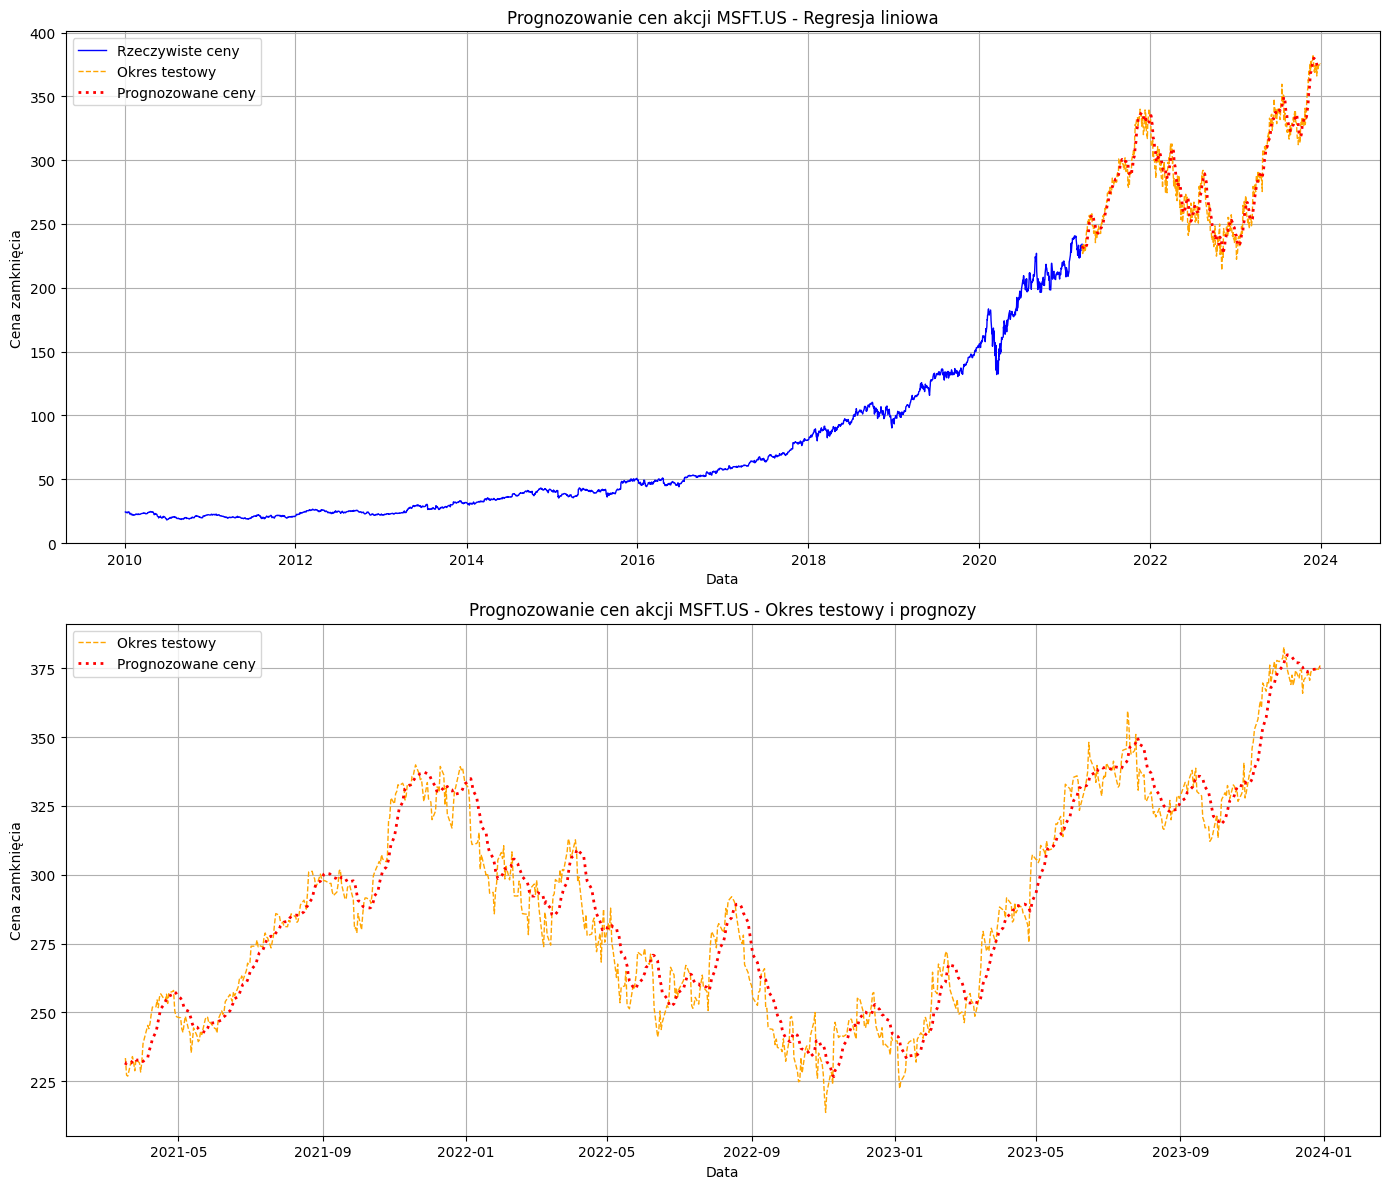

In [9]:
# link do filmiku z objaśnieniem kodu:
# https://www.youtube.com/watch?v=ltXSoduiVwY

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Klasa implementująca regresję liniową
class LinearRegression:

        def __init__(self, learning_rate = 0.001, num_iterations = 1000):
            self.learning_rate = learning_rate
            self.num_iterations = num_iterations
            self.weights = None
            self.bias = None

        # Funkcja do trenowania modelu regresji liniowej
        def fit(self, X, y):
            n_samples, n_features = X.shape
            self.weights = np.zeros(n_features)
            self.bias = 0

            for _ in range(self.num_iterations):
                y_predicted = np.dot(X, self.weights) + self.bias

                dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
                db = (1/n_samples) * np.sum(y_predicted - y)

                self.weights = self.weights - self.learning_rate * dw 
                self.bias = self.bias - self.learning_rate * db

        # Funkcja do predykcji modelu
        def predict(self, X):
            y_predicted = np.dot(X, self.weights) + self.bias
            return y_predicted

# Przygotowanie danych
X_train = X_train.reshape(X_train.shape[0], -1)  
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.flatten()  
y_test = y_test.flatten()

# Uczenie modelu
reg = LinearRegression(learning_rate=0.01, num_iterations=100000)
reg.fit(X_train, y_train)

# Predykcja
predictions = reg.predict(X_test)

# Obliczanie błędu MSE
#def mse(y_test, predictions):
#    return np.mean((y_test - predictions) ** 2)

# mse_value = mse(y_test, predictions)
# print("MSE:", mse_value)

# Obliczanie błędów
def evaluate(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

mse_value, rmse_value, r2_value = evaluate(y_test, predictions)

# Wyświetlenie błędów
print(f'MSE (Mean Squared Error): {mse_value:.4f}')
print(f'RMSE (Root Mean Squared Error): {rmse_value:.4f}')
print(f'R² (R-squared): {r2_value:.4f}')

# Denormalizacja danych dla wizualizacji
y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_denorm = scaler.inverse_transform(predictions.reshape(-1, 1))

def plot_results_linear(df, data, test_data, predicted_data, title):
    
    if len(predicted_data.shape) > 1:
        predicted_data = predicted_data.flatten()  

    predicted_data = predicted_data[:len(test_data)]

    # Tworzenie wykresu z dwoma podwykresami
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Wykres rzeczywistych cen, okresu testowego i prognoz
    ax1.plot(df['Date'][:split + seq_length], data[:split + seq_length], color='blue', label='Rzeczywiste ceny', linewidth=1)
    ax1.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax1.plot(df['Date'][split + seq_length:], predicted_data, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax1.set_xlabel('Data')
    ax1.set_ylabel('Cena zamknięcia')
    ax1.set_title(f'Prognozowanie cen akcji MSFT.US - {title}')
    ax1.legend()
    ax1.grid(True)

    # Wykres przybliżenia okresu testowego i prognoz
    ax2.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax2.plot(df['Date'][split + seq_length:], predicted_data, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax2.set_xlabel('Data')
    ax2.set_ylabel('Cena zamknięcia')
    ax2.set_title('Prognozowanie cen akcji MSFT.US - Okres testowy i prognozy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()  
    plt.show()

# Wywołanie funkcji 
plot_results_linear(df, data, data[split + seq_length:], predicted_data=predictions_denorm, title='Regresja liniowa')

### Model regresji logistycznej

In [10]:
# link do filmiku z objaśnieniem kodu:
# https://www.youtube.com/watch?v=YYEJ_GUguHw

import numpy as np

# Funkcja sigmoidalna
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Klasa implementująca regresję logistyczną
class LogisticRegression():

    def __init__(self, learning_rate=0.001, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    # Funkcja do trenowania modelu regresji logistyczna
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.num_iterations):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = sigmoid(linear_pred)

            dw = (1/n_samples) * np.dot(X.T, (predictions - y))
            db = (1/n_samples) * np.sum(predictions-y)

            self.weights = self.weights - self.learning_rate * dw
            self.bias = self.bias - self.learning_rate * db

    # Funkcja do predykcji modelu
    def predict(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        y_pred = sigmoid(linear_pred)
        class_pred = [0 if y<=0.5 else 1 for y in y_pred]
        return class_pred

### Model ARIMA

RMSE: 105.42720046562724
R²: -6.64075412895965


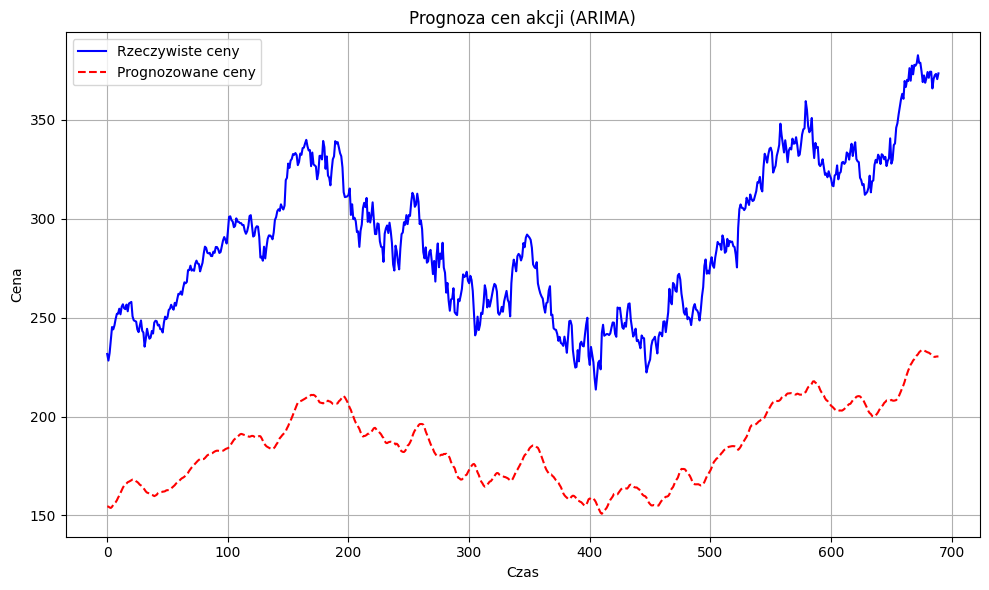

In [11]:

# link do strony z objaśnieniem kodu:
# https://burakayy.com/blog/how-arima-works

import numpy as np
import matplotlib.pyplot as plt

# Funkcja do przygotowania danych dla AR i MA
# order - liczba przeszlych wartości używana do predykcji
def prepare_data_arima(data, order):
    X, y = [], []
    for i in range(order, len(data)):
        X.append(data[i - order:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Autoregresyjny model (AR)
def autoregressive_model(data, learning_rate, epochs, order, cost_function):
    X, y = prepare_data_arima(data, order)
    weights = np.zeros(order)
    bias = 0

    for _ in range(epochs):
        predictions = np.dot(X, weights) + bias
        error = predictions - y

        if cost_function == 'mse':
            gradient_weights = 2 * np.dot(X.T, error) / len(X)
            gradient_bias = 2 * np.sum(error) / len(X)
        elif cost_function == 'mae':
            gradient_weights = np.dot(X.T, np.sign(error)) / len(X)
            gradient_bias = np.sum(np.sign(error)) / len(X)
        elif cost_function == 'rmse':
            gradient_weights = (2 * np.dot(X.T, error) / len(X)) / (2 * np.sqrt(np.mean(error**2)))
            gradient_bias = (2 * np.sum(error) / len(X)) / (2 * np.sqrt(np.mean(error**2)))

        weights -= learning_rate * gradient_weights
        #bias -= learning_rate * gradient_bias

    return weights, bias

# Model średniej ruchomej (MA)
def moving_average_model(errors, learning_rate, epochs, order, cost_function):
    X, y = prepare_data_arima(errors, order)
    theta = np.zeros(order)
    bias = np.mean(y)

    for _ in range(epochs):
        predictions = np.dot(X, theta) + bias
        error = predictions - y

        if cost_function == 'mse':
            gradient_weights = 2 * np.dot(X.T, error) / len(X)
            gradient_bias = 2 * np.sum(error) / len(X)
        elif cost_function == 'mae':
            gradient_weights = np.dot(X.T, np.sign(error)) / len(X)
            gradient_bias = np.sum(np.sign(error)) / len(X)
        elif cost_function == 'rmse':
            gradient_weights = (2 * np.dot(X.T, error) / len(X)) / (2 * np.sqrt(np.mean(error**2)))
            gradient_bias = (2 * np.sum(error) / len(X)) / (2 * np.sqrt(np.mean(error**2)))

        theta -= learning_rate * gradient_weights
        #bias -= learning_rate * gradient_bias

    return theta, bias

# Funkcja ARIMA
def arima(data, p, q, epochs, cost_function, train_size=0.8):
    # Przygotowanie danych
    data = data.flatten()
    train_size_idx = int(len(data) * train_size)
    train, test = data[:train_size_idx], data[train_size_idx:]

    # Składnik AR
    ar_weights, ar_bias = autoregressive_model(train, learning_rate=0.01, epochs=epochs, order=p, cost_function=cost_function)
    X_train_ar, y_train_ar = prepare_data_arima(train, p)
    ar_predictions_train = np.dot(X_train_ar, ar_weights) + ar_bias
    ar_errors = y_train_ar - ar_predictions_train

    # Składnik MA
    ma_weights, ma_bias = moving_average_model(ar_errors, learning_rate=0.01, epochs=epochs, order=q, cost_function=cost_function)
    X_test_ar, y_test_ar = prepare_data_arima(test, p)
    ar_predictions_test = np.dot(X_test_ar, ar_weights) + ar_bias
    X_test_ma, y_test_ma = prepare_data_arima(ar_predictions_test - y_test_ar, q)
    ma_predictions_test = np.dot(X_test_ma, ma_weights) + ma_bias

    # Łączenie składników AR i MA
    final_predictions = ar_predictions_test[:len(ma_predictions_test)] + ma_predictions_test

    return final_predictions, test[p:len(final_predictions) + p]

# Wywołanie modelu ARIMA
p, q = 10, 5
epochs = 100
cost_function = 'mse'

# Prognozowanie
predictions, actual = arima(data=scaled_data, p=p, q=q, epochs=epochs, cost_function=cost_function)

# Odwracanie skalowania dla interpretacji wyników
predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1, 1))
actual_original_scale = scaler.inverse_transform(np.array(actual).reshape(-1, 1))

# Obliczanie RMSE
rmse = np.sqrt(mean_squared_error(actual_original_scale, predictions_original_scale))

# Obliczanie R²
r2 = r2_score(actual_original_scale, predictions_original_scale)

# Wyświetlanie wyników RMSE i R²
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# Rysowanie wykresu
plt.figure(figsize=(10, 6))
plt.plot(actual_original_scale, label='Rzeczywiste ceny', color='blue')
plt.plot(predictions_original_scale, label='Prognozowane ceny', color='red', linestyle='dashed')
plt.title('Prognoza cen akcji (ARIMA)')
plt.xlabel('Czas')
plt.ylabel('Cena')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Model SVM

In [15]:
# link do filmiku z objaśnieniem kodu:
# https://www.youtube.com/watch?v=T9UcK-TxQGw

import numpy as np

class SVM:

    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)

        # init weights
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]


    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)


### Las losowy

In [14]:
# link do filmiku z objaśnieniem kodu:
# https://www.youtube.com/watch?v=kFwe2ZZU7yw

import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
        
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions